In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
sns.set_style("whitegrid")

In [2]:
%matplotlib inline

In [3]:
summary = pd.read_csv("atussum_2013.dat")
summary.info()

def activity_by_age(df, activity_code, subsample=True):
    activity_col = "t{}".format(activity_code)
    df = df[['TUFINLWGT', 'TEAGE', activity_col]]
    df = df.rename(columns={"TUFINLWGT": "weight", "TEAGE": "age", activity_col: "minutes"})
    if subsample:
        df = df[df.age % 5 == 0]
    df['weighted_minutes'] = df.weight * df.minutes
    df = df.groupby("age").sum()
    df['mean_minutes'] = df.weighted_minutes / df.weight
    df = df[['mean_minutes']]
    return df

def linear_least_squares(df, fn):
    values = df.index.map(fn)
    diffs = df.mean_minutes - values
    diffs_squared = diffs ** 2
    return diffs_squared.sum() / (2 * len(diffs)) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Columns: 413 entries, tucaseid to t500107
dtypes: float64(1), int64(412)
memory usage: 36.0 MB


In [6]:
sleep_data = summary[['TUFINLWGT', 'TEAGE', 'TESEX', 't010101']]
sleep_data = sleep_data.rename(columns={"TUFINLWGT": "weight", "TEAGE": "age", "TESEX": "sex", "t010101": "minutes"})
sleep_data['weighted_minutes'] = sleep_data.weight * sleep_data.minutes
sleep_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Data columns (total 5 columns):
weight              11385 non-null float64
age                 11385 non-null int64
sex                 11385 non-null int64
minutes             11385 non-null int64
weighted_minutes    11385 non-null float64
dtypes: float64(2), int64(3)
memory usage: 533.7 KB


In [7]:
sleep_by_age = sleep_data.groupby("age").sum()
sleep_by_age.head()

,weight,sex,minutes,weighted_minutes
age,,,,
15,1.168895e+09,159,62992,6.645155e+11
16,1.807565e+09,243,96196,1.013404e+12
17,1.929189e+09,246,96861,1.094304e+12
18,1.419704e+09,165,64722,8.498931e+11
19,1.307960e+09,130,50557,7.508169e+11


In [8]:
sleep_by_age['mean_minutes'] = sleep_by_age.weighted_minutes / sleep_by_age.weight
sleep_by_age.head()

,weight,sex,minutes,weighted_minutes,mean_minutes
age,,,,,
15,1.168895e+09,159,62992,6.645155e+11,568.498993
16,1.807565e+09,243,96196,1.013404e+12,560.646005
17,1.929189e+09,246,96861,1.094304e+12,567.235373
18,1.419704e+09,165,64722,8.498931e+11,598.641088
19,1.307960e+09,130,50557,7.508169e+11,574.036484


In [ ]:
sleep_by_age.loc[38].mean_minutes / 60

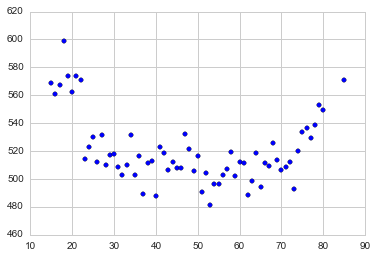

In [9]:
plt.scatter(sleep_by_age.index, sleep_by_age.mean_minutes)

In [10]:
regression = linear_model.LinearRegression()
transposed_sleep_values = np.array(sleep_by_age.index.values).reshape((-1, 1))
regression.fit(transposed_sleep_values, sleep_by_age.mean_minutes.values)
print(regression.coef_, regression.intercept_)

[-0.3727603] 538.764180347


In [11]:
def plot_regression(fn):
    plt.scatter(sleep_by_age.index, sleep_by_age.mean_minutes)
    xmin, xmax = plt.xlim()
    xs = np.linspace(xmin, xmax, 100)
    plt.plot(xs, [fn(x) for x in xs])

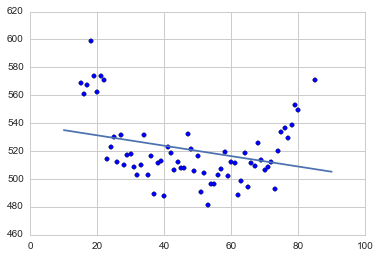

In [12]:
fn = lambda x: regression.predict(x)[0]

plot_regression(fn)

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [15]:
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])
model = model.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)

print(model.named_steps['linear'].coef_)

[  6.45733647e+02  -5.66518847e+00   5.48318311e-02]


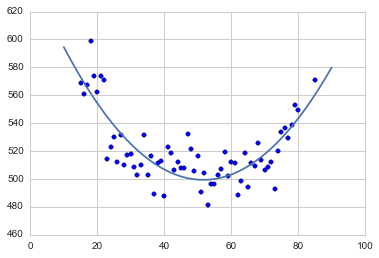

In [16]:
fn = lambda x: model.predict(x)[0]
plot_regression(fn)

In [18]:
model.predict(32) / 60

array([ 8.67659018])

In [ ]:
model.predict(50) / 60

[ 520.84943152]


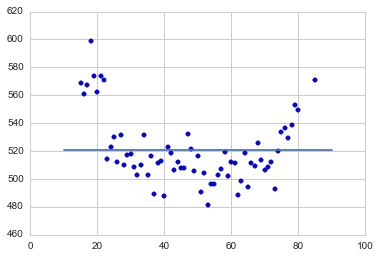

In [19]:
model = Pipeline([('poly', PolynomialFeatures(degree=0)),
                  ('linear', LinearRegression(fit_intercept=False))])
model = model.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)


print(model.named_steps['linear'].coef_)

fn = lambda x: model.predict(x)[0]

plot_regression(fn)

[  5.38764180e+02  -3.72760302e-01]


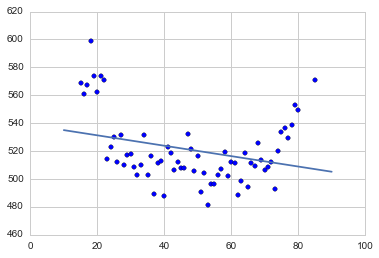

In [20]:
model = Pipeline([('poly', PolynomialFeatures(degree=1)),
                  ('linear', LinearRegression(fit_intercept=False))])
model = model.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)

print(model.named_steps['linear'].coef_)

fn = lambda x: model.predict(x)[0]

plot_regression(fn)

[  0.00000000e+00  -1.96775534e+01   4.95578215e-01  -4.70230260e-03
  -1.15898708e-06   1.87993805e-07]


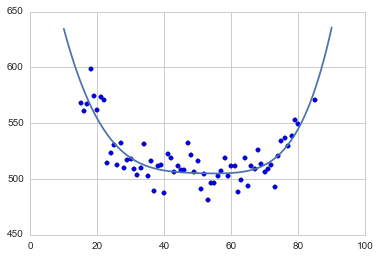

In [25]:

from sklearn.linear_model import Ridge
model = Pipeline([('poly', PolynomialFeatures(degree=5)),
                  ('linear', LinearRegression())])
model = model.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)

print(model.named_steps['linear'].coef_)
fn = lambda x: model.predict(x)[0]

plot_regression(fn)

[  0.00000000e+00  -4.12828643e-05  -9.08344345e-06  -1.56606931e-04
  -1.54756470e-03   1.10207603e-04  -3.18351478e-06   4.61845298e-08
  -3.34619263e-10   9.66018225e-13  -7.95726712e-19]


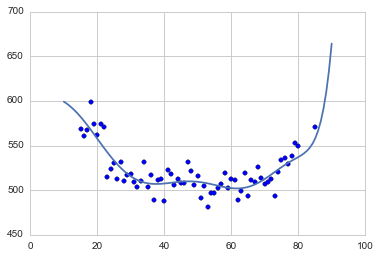

In [33]:

from sklearn.linear_model import Ridge
model = Pipeline([('poly', PolynomialFeatures(degree=10)),
                  ('linear', LinearRegression())])
model = model.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)

print(model.named_steps['linear'].coef_)
fn = lambda x: model.predict(x)[0]

plot_regression(fn)